<div align="center">
    
# Investigating and Mitigating Demographic Biases in True Positive Rates of Drug Consumption Analysis Across Age, Gender, and Ethnicity

# Bhavyakumar Ramani and Hassan Shah

# Department of Data Science, University of Southern California, Los Angeles, California 90007, USA

# DSCI 531 - Spring 2024
</div>

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from math import ceil
from ucimlrepo import fetch_ucirepo 

### Dataset Setup

In [2]:
# fetch dataset 
drug_consumption_quantified = fetch_ucirepo(id=373) 
  
# data (as pandas dataframes) 
X = drug_consumption_quantified.data.features 
y = drug_consumption_quantified.data.targets 

In [3]:
df = drug_consumption_quantified['data']['original']

df.head()

   id      age   gender  education  country  ethnicity   nscore   escore  \
0   1  0.49788  0.48246   -0.05921  0.96082    0.12600  0.31287 -0.57545   
1   2 -0.07854 -0.48246    1.98437  0.96082   -0.31685 -0.67825  1.93886   
2   3  0.49788 -0.48246   -0.05921  0.96082   -0.31685 -0.46725  0.80523   
3   4 -0.95197  0.48246    1.16365  0.96082   -0.31685 -0.14882 -0.80615   
4   5  0.49788  0.48246    1.98437  0.96082   -0.31685  0.73545 -1.63340   

    oscore   ascore   cscore  impuslive       ss alcohol amphet amyl benzos  \
0 -0.58331 -0.91699 -0.00665   -0.21712 -1.18084     CL5    CL2  CL0    CL2   
1  1.43533  0.76096 -0.14277   -0.71126 -0.21575     CL5    CL2  CL2    CL0   
2 -0.84732 -1.62090 -1.01450   -1.37983  0.40148     CL6    CL0  CL0    CL0   
3 -0.01928  0.59042  0.58489   -1.37983 -1.18084     CL4    CL0  CL0    CL3   
4 -0.45174 -0.30172  1.30612   -0.21712 -0.21575     CL4    CL1  CL1    CL0   

  caff cannabis choc coke crack ecstasy heroin ketamine legalh  lsd 

In [4]:
df.columns

Index(['id', 'age', 'gender', 'education', 'country', 'ethnicity', 'nscore',
       'escore', 'oscore', 'ascore', 'cscore', 'impuslive', 'ss', 'alcohol',
       'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 'choc', 'coke', 'crack',
       'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 'mushrooms',
       'nicotine', 'semer', 'vsa'],
      dtype='object')

### Preprocessing and Feature Engineering

In [6]:
user_id = 'id'
protect_class = ['age', 'gender', 'education', 'country', 'ethnicity']
personality = ['nscore', 'escore', 'oscore', 'ascore', 'cscore', 'impuslive', 'ss']

drugs = ['alcohol', 'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 'choc', 'coke', 'crack',
       'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 'mushrooms', 'nicotine', 'semer', 'vsa']
drugs_legal = ['alcohol', 'caff', 'choc', 'nicotine']
drugs_illegal = ['amphet', 'amyl', 'benzos', 'cannabis', 'coke', 'crack', 'ecstasy', 
                 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 'mushrooms', 'semer', 'vsa']

In [7]:
def encode_one_hot(column, df, encoder=None):
    if encoder is None:
        encoder = OneHotEncoder(sparse=False)
    encoded_data = encoder.fit_transform(df[[column]])
    return pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([column]))

# Map consumption categories
consumption_cat2num = {'CL0': 0, 'CL1': 1, 'CL2': 2, 'CL3': 3, 'CL4': 4, 'CL5': 5, 'CL6': 6}
for drug in drugs:
    if drug in df.columns:  # Check if the drug column exists in DataFrame
        df[drug] = df[drug].map(consumption_cat2num) 
        
df = df.drop(columns='id', errors='ignore')

# Mapping for country and ethnicity
country_map = {-0.09765: 'Australia', 0.24923: 'Canada', -0.46841: 'New Zealand', -0.28519: 'Other',
               0.21128: 'Republic of Ireland', 0.96082: 'UK', -0.57009: 'USA'}
df['country'] = df['country'].map(country_map)

ethnicity_map = {-0.50212: 'Asian', -1.10702: 'Black', 1.90725: 'Mixed-Black/Asian', 0.12600: 'Mixed-White/Asian',
                 -0.22166: 'Mixed-White/Black', 0.11440: 'Other', -0.31685: 'White'}
df['ethnicity'] = df['ethnicity'].map(ethnicity_map)

# One-hot encode categorical columns
df = pd.concat([df, encode_one_hot('country', df)], axis=1).drop('country', axis=1)
df = pd.concat([df, encode_one_hot('ethnicity', df)], axis=1).drop('ethnicity', axis=1)

df.head()

/Users/hassanhshah/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/hassanhshah/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,age,gender,education,nscore,escore,oscore,ascore,cscore,impuslive,ss,alcohol,amphet,amyl,benzos,caff,cannabis,choc,coke,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,semer,vsa,country_nan,ethnicity_Asian,ethnicity_Black,ethnicity_Mixed-Black/Asian,ethnicity_Mixed-White/Asian,ethnicity_Mixed-White/Black,ethnicity_Other,ethnicity_White
0,0.49788,0.48246,-0.05921,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,5,2,0,2,6,0,5,0,0,0,0,0,0,0,0,0,2,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.07854,-0.48246,1.98437,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,5,2,2,0,6,4,6,3,0,4,0,2,0,2,3,0,4,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.49788,-0.48246,-0.05921,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,6,0,0,0,6,3,4,0,0,0,0,0,0,0,0,1,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.95197,0.48246,1.16365,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,4,0,0,3,5,2,4,2,0,0,0,2,0,0,0,0,2,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.49788,0.48246,1.98437,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,4,1,1,0,6,3,6,0,0,1,0,0,1,0,0,2,2,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,-0.95197,0.48246,-0.61113,-1.19430,1.74091,1.88511,0.76096,-1.13788,0.88113,1.92173,5,0,0,0,4,5,4,0,0,0,0,0,3,3,0,0,0,0,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1881,-0.95197,-0.48246,-0.61113,-0.24649,1.74091,0.58331,0.76096,-1.51840,0.88113,0.76540,5,0,0,0,5,3,4,0,0,2,0,0,3,5,4,4,5,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1882,-0.07854,0.48246,0.45468,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,0.52975,-0.52593,4,6,5,5,6,6,6,4,0,4,0,2,0,2,0,2,6,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1883,-0.95197,0.48246,-0.61113,0.91093,-1.92173,0.29338,-1.62090,-2.57309,1.29221,1.22470,5,0,0,0,6,6,5,0,0,3,0,0,3,3,0,3,4,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
#drop semeron users (overclaimers)
df = df.drop(index=df[df['semer'] > 0].index)
df = df.drop(columns='semer')

try:
    drugs.remove('semer')
    drugs_illegal.remove('semer')
except ValueError:
    pass

# reset row index
df = df.reset_index(drop=True)

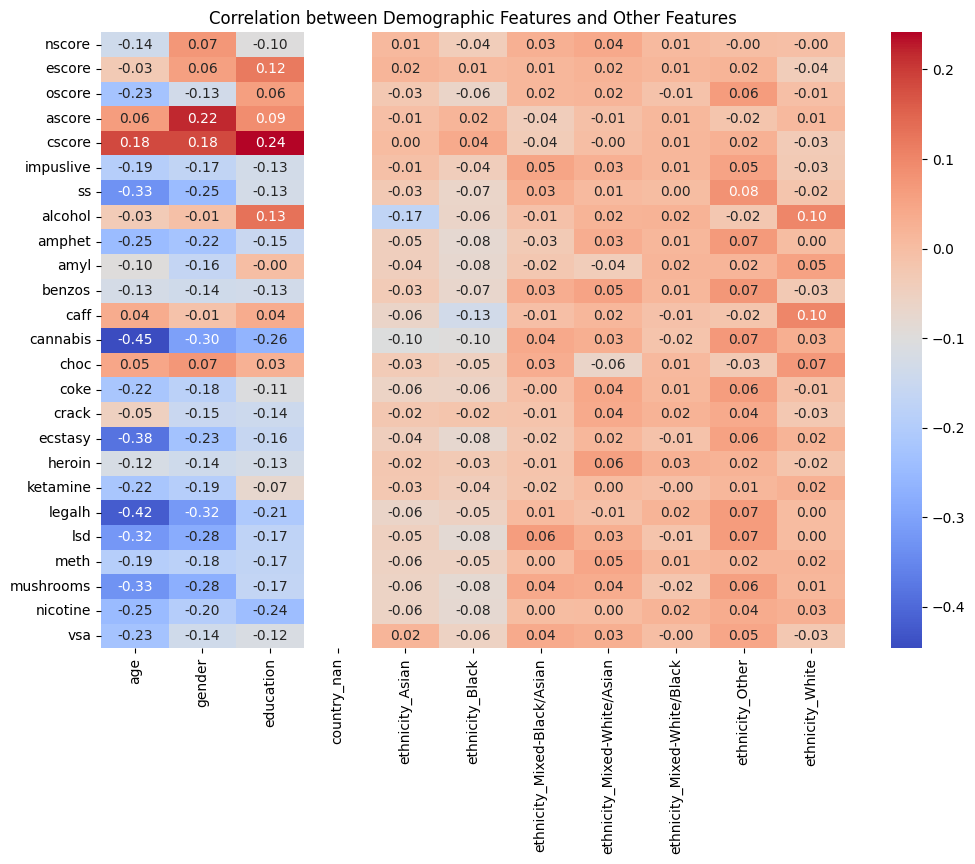

In [9]:
country_columns = [col for col in df.columns if col.startswith('country_')]
ethnicity_columns = [col for col in df.columns if col.startswith('ethnicity_')]

# Update the protected class list to include these new columns and exclude 'country' and 'ethnicity'
updated_protect_class = [col for col in protect_class if col not in ['country', 'ethnicity']] + country_columns + ethnicity_columns

correlation_matrix = df.corr()

protected_correlations = correlation_matrix[updated_protect_class].drop(index=updated_protect_class, errors='ignore')

plt.figure(figsize=(12, 8))
sns.heatmap(protected_correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Demographic Features and Other Features')
plt.show()

In [10]:
# Consider a person a "illegal_user" (1) if he/she consumed any illegal drug in the last year
df['illegal_user'] = df[drugs_illegal].apply(lambda x: (x >= 3).any(), axis=1).astype(int)

In [11]:
df['illegal_user'].value_counts()

illegal_user
1    1171
0     706
Name: count, dtype: int64

### *View Appendix at end of notebook for Exploratory Data Analysis*

### Model Evaluation & Bias Analysis

In [12]:
feature_columns = [col for col in df.columns if col not in drugs_illegal + ['illegal_user']]

X = df[feature_columns]
y = df['illegal_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False)
}

results = []
trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    y_pred = model.predict(X_test)

    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred)
    }

    results.append(metrics)

result_df = pd.DataFrame(results)
print(result_df)

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.811170   0.830435  0.856502  0.843267  0.800800
1          Naive Bayes  0.787234   0.806867  0.843049  0.824561  0.774466
2        Decision Tree  0.718085   0.755459  0.775785  0.765487  0.704886
3                  KNN  0.776596   0.820276  0.798206  0.809091  0.771652
4                  SVM  0.824468   0.848889  0.856502  0.852679  0.817140
5        Random Forest  0.803191   0.822511  0.852018  0.837004  0.792022
6              XGBoost  0.781915   0.802575  0.838565  0.820175  0.768956


In [13]:
best_model = trained_models['SVM']

# Define the mappings for age and education
age_mapping = {-0.95197: '18-24', -0.07854: '25-34', 0.49788: '35-44',
               1.09449: '45-54', 1.82213: '55-64', 2.59171: '65+'}

education_mapping = {-2.43591: '<16 years', -1.73790: '16 years',
                     -1.43719: '17 years', -1.22751: '18 years',
                     -0.61113: 'Some college',
                     -0.05921: 'Prof cert/diploma', 0.45468: 'University degree',
                     1.16365: 'Masters degree', 1.98437: 'Doctorate'}

gender_mapping = {0.48246: 'Female', -0.48246: 'Male'}

# Define the sensitive attributes
sensitive_attrs = ['age', 'gender', 'education']  # Removed individual country and ethnicity columns

# Create separate lists for countries and ethnicities to aggregate them later
country_attrs = [col for col in df.columns if col.startswith('country')]
ethnicity_attrs = [col for col in df.columns if col.startswith('ethnicity')]

# Calculate TPR disparities and map the values to labels
tpr_disparities = {}
tpr_labels = {}
counts = {}
for attr in sensitive_attrs + ['country', 'ethnicity']:
    subgroup_tprs = []
    subgroup_labels = []
    subgroup_counts = []
    
    # Special handling for country and ethnicity
    if attr in ['country', 'ethnicity']:
        attr_list = country_attrs if attr == 'country' else ethnicity_attrs
        
        for subgroup_attr in attr_list:
            subgroup = 1
            subgroup_mask = df[subgroup_attr] == subgroup
            subgroup_X_test = X_test.loc[subgroup_mask, best_model.feature_names_in_]
            subgroup_y_test = y_test.loc[subgroup_mask]

            subgroup_y_pred = best_model.predict(subgroup_X_test)
            subgroup_tpr = recall_score(subgroup_y_test, subgroup_y_pred, zero_division=0)
            subgroup_tprs.append(subgroup_tpr)
            
            subgroup_labels.append(subgroup_attr.split('_')[-1])
            subgroup_counts.append(subgroup_mask.sum())
            
    else:  # Original handling for age, gender, and education
        for subgroup in sorted(df[attr].unique()):
            subgroup_mask = df[attr] == subgroup
            subgroup_X_test = X_test.loc[subgroup_mask, best_model.feature_names_in_]
            subgroup_y_test = y_test.loc[subgroup_mask]

            subgroup_y_pred = best_model.predict(subgroup_X_test)
            subgroup_tpr = recall_score(subgroup_y_test, subgroup_y_pred, zero_division=0)
            subgroup_tprs.append(subgroup_tpr)
            subgroup_counts.append(subgroup_mask.sum())

            # Map the subgroup to the correct label
            if attr == 'age':
                subgroup_labels.append(age_mapping.get(subgroup, str(subgroup)))
            elif attr == 'education':
                subgroup_labels.append(education_mapping.get(subgroup, str(subgroup)))
            elif attr == 'gender':
                subgroup_labels.append(gender_mapping.get(subgroup, str(subgroup)))

    tpr_disparities[attr] = subgroup_tprs
    tpr_labels[attr] = subgroup_labels
    counts[attr] = subgroup_counts

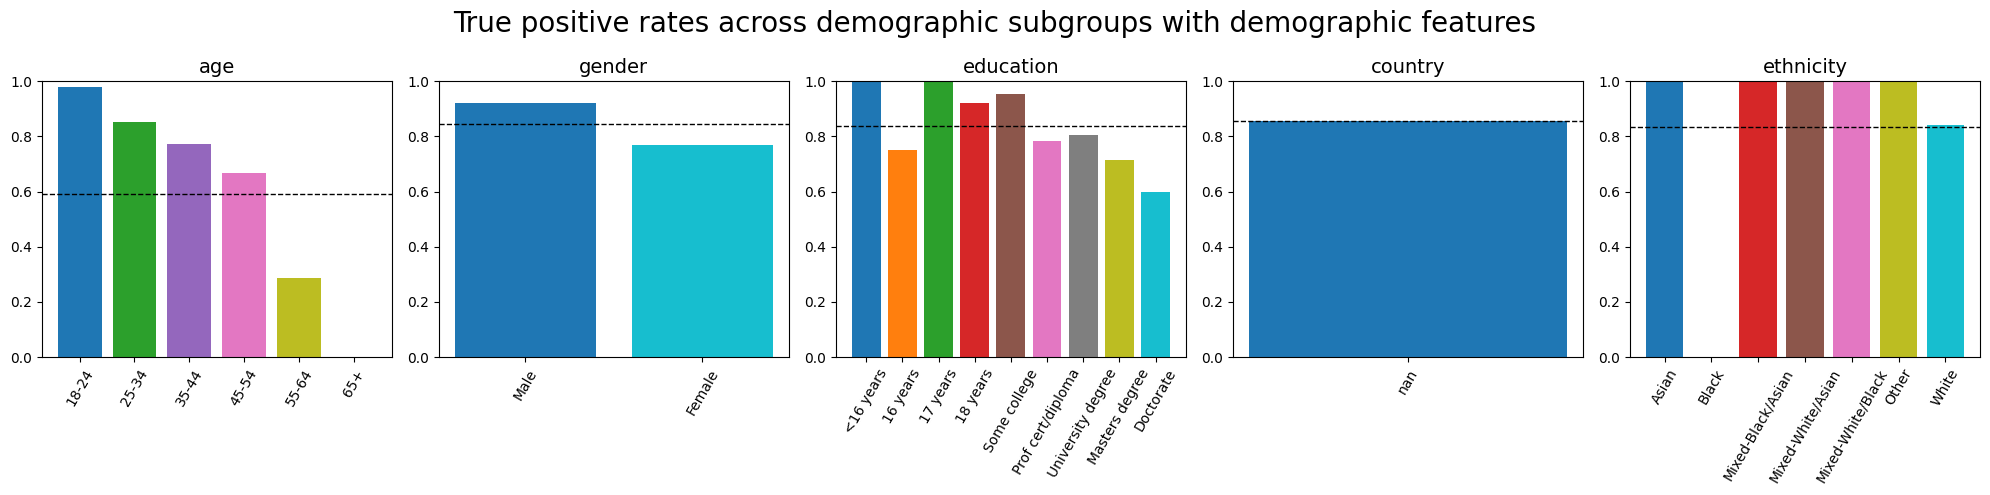

In [14]:
fig = plt.figure(figsize=(20, 5), dpi=100)
num_attrs = len(sensitive_attrs) + 2

for i, attr in enumerate(sensitive_attrs + ['country', 'ethnicity']):
    ax = fig.add_subplot(1, num_attrs, i + 1)
    color_sequence = plt.cm.tab10(np.linspace(0, 1, len(tpr_disparities[attr])))
    
    ax.bar(range(len(tpr_disparities[attr])), tpr_disparities[attr], color=color_sequence)
    ax.set_title(attr, fontsize=14)
    ax.set_ylim(0, 1)
    ax.set_xticks(range(len(tpr_labels[attr])))
    ax.set_xticklabels(tpr_labels[attr], rotation=60, fontsize=10)
    avg_tpr = sum(tpr_disparities[attr]) / len(tpr_disparities[attr])
    ax.axhline(y=avg_tpr, color='black', linestyle='--', linewidth=1)

fig.suptitle('True positive rates across demographic subgroups with demographic features', fontsize=20)  # Set the title for the whole figure
plt.tight_layout()
plt.show()

In [15]:
feature_columns = [col for col in df.columns if col not in protect_class + drugs_illegal + ['illegal_user']]

X = df[feature_columns]
y = df['illegal_user']

X_train_noprotec, X_test_noprotec, y_train_noprotec, y_test_noprotec = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False)
}

results = []
trained_models = {}
for name, model in models.items():
    model.fit(X_train_noprotec, y_train_noprotec)
    trained_models[name] = model  # Store the trained model

    # Make predictions on the test set
    y_pred_noprotec = model.predict(X_test_noprotec)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_noprotec, y_pred_noprotec)
    precision = precision_score(y_test_noprotec, y_pred_noprotec)
    recall = recall_score(y_test_noprotec, y_pred_noprotec)
    f1 = f1_score(y_test_noprotec, y_pred_noprotec)
    roc_auc = roc_auc_score(y_test_noprotec, y_pred_noprotec)

    # Store the results
    results.append([name, accuracy, precision, recall, f1, roc_auc])

result_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])
print(result_df)

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.803191   0.814346  0.865471  0.839130  0.788945
1          Naive Bayes  0.787234   0.789474  0.874439  0.829787  0.767285
2        Decision Tree  0.720745   0.756522  0.780269  0.768212  0.707128
3                  KNN  0.765957   0.802691  0.802691  0.802691  0.757554
4                  SVM  0.808511   0.815900  0.874439  0.844156  0.793429
5        Random Forest  0.771277   0.784232  0.847534  0.814655  0.753832
6              XGBoost  0.765957   0.792208  0.820628  0.806167  0.753451


In [16]:
best_model = trained_models['SVM']

age_mapping = {-0.95197: '18-24', -0.07854: '25-34', 0.49788: '35-44',
               1.09449: '45-54', 1.82213: '55-64', 2.59171: '65+'}

education_mapping = {-2.43591: '<16 years', -1.73790: '16 years',
                     -1.43719: '17 years', -1.22751: '18 years',
                     -0.61113: 'Some college',
                     -0.05921: 'Prof cert/diploma', 0.45468: 'University degree',
                     1.16365: 'Masters degree', 1.98437: 'Doctorate'}

gender_mapping = {0.48246: 'Female', -0.48246: 'Male'}

sensitive_attrs = ['age', 'gender', 'education']

country_attrs = [col for col in df.columns if col.startswith('country')]
ethnicity_attrs = [col for col in df.columns if col.startswith('ethnicity')]

tpr_disparities = {}
tpr_labels = {}
counts = {}
for attr in sensitive_attrs + ['country', 'ethnicity']:
    subgroup_tprs = []
    subgroup_labels = []
    subgroup_counts = []
    
    if attr in ['country', 'ethnicity']:
        attr_list = country_attrs if attr == 'country' else ethnicity_attrs
        
        for subgroup_attr in attr_list:
            subgroup = 1
            subgroup_mask = df[subgroup_attr] == subgroup
            subgroup_X_test = X_test.loc[subgroup_mask, best_model.feature_names_in_]
            subgroup_y_test = y_test.loc[subgroup_mask]

            subgroup_y_pred = best_model.predict(subgroup_X_test)
            subgroup_tpr = recall_score(subgroup_y_test, subgroup_y_pred, zero_division=0)
            subgroup_tprs.append(subgroup_tpr)
            
            subgroup_labels.append(subgroup_attr.split('_')[-1])
            subgroup_counts.append(subgroup_mask.sum())
            
    else:
        for subgroup in sorted(df[attr].unique()):
            subgroup_mask = df[attr] == subgroup
            subgroup_X_test = X_test.loc[subgroup_mask, best_model.feature_names_in_]
            subgroup_y_test = y_test.loc[subgroup_mask]

            subgroup_y_pred = best_model.predict(subgroup_X_test)
            subgroup_tpr = recall_score(subgroup_y_test, subgroup_y_pred, zero_division=0)
            subgroup_tprs.append(subgroup_tpr)
            subgroup_counts.append(subgroup_mask.sum())

            if attr == 'age':
                subgroup_labels.append(age_mapping.get(subgroup, str(subgroup)))
            elif attr == 'education':
                subgroup_labels.append(education_mapping.get(subgroup, str(subgroup)))
            elif attr == 'gender':
                subgroup_labels.append(gender_mapping.get(subgroup, str(subgroup)))

    tpr_disparities[attr] = subgroup_tprs
    tpr_labels[attr] = subgroup_labels
    counts[attr] = subgroup_counts

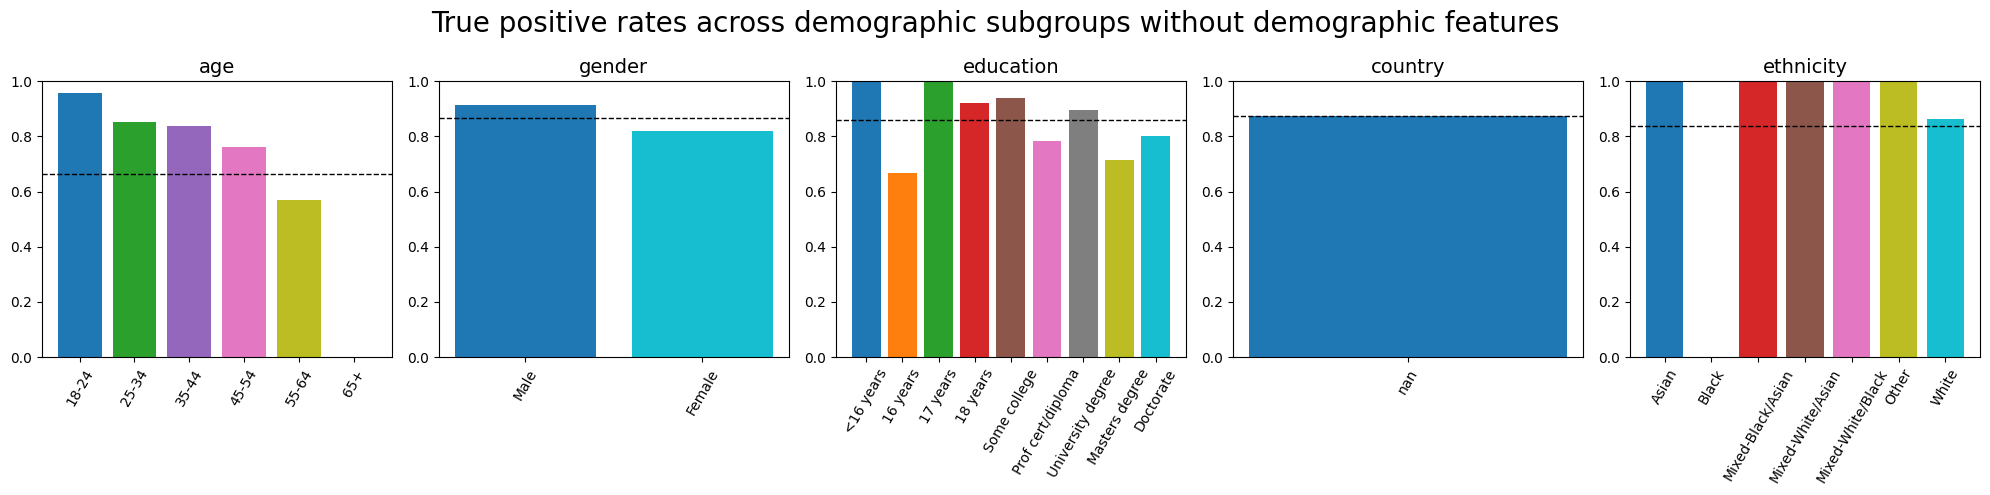

In [17]:
fig = plt.figure(figsize=(20, 5), dpi=100)
num_attrs = len(sensitive_attrs) + 2

for i, attr in enumerate(sensitive_attrs + ['country', 'ethnicity']):
    ax = fig.add_subplot(1, num_attrs, i + 1)
    color_sequence = plt.cm.tab10(np.linspace(0, 1, len(tpr_disparities[attr])))
    
    ax.bar(range(len(tpr_disparities[attr])), tpr_disparities[attr], color=color_sequence)
    ax.set_title(attr, fontsize=14)
    ax.set_ylim(0, 1)
    ax.set_xticks(range(len(tpr_labels[attr])))
    ax.set_xticklabels(tpr_labels[attr], rotation=60, fontsize=10)
    avg_tpr = sum(tpr_disparities[attr]) / len(tpr_disparities[attr])
    ax.axhline(y=avg_tpr, color='black', linestyle='--', linewidth=1)

fig.suptitle('True positive rates across demographic subgroups without demographic features', fontsize=20)  # Set the title for the whole figure
plt.tight_layout()
plt.show()

### Appendix: Extended Exploratory Data Analysis

In [18]:
drug_consumption_quantified = fetch_ucirepo(id=373) 
  
X = drug_consumption_quantified.data.features 
y = drug_consumption_quantified.data.targets 

df = drug_consumption_quantified['data']['original']

education_map = {
    -2.43591: "Left school before 16 years",
    -1.73790: "Left school at 16 years",
    -1.43719: "Left school at 17 years",
    -1.22751: "Left school at 18 years",
    -0.61113: "Some college or university, no certificate or degree",
    -0.05921: "Professional certificate/ diploma",
    0.45468: "University degree",
    1.16365: "Masters degree",
    1.98437: "Doctorate degree"
}

age_map = {
    -0.95197: "18-24",
    -0.07854: "25-34",
    0.49788: "35-44",
    1.09449: "45-54",
    1.82213: "55-64",
    2.59171: "65+"
}

gender_map = {
    0.48246: "Female",
    -0.48246: "Male"
}

ethnicity_map = {
    -0.50212: "Asian",
    -1.10702: "Black",
    1.90725: "Mixed-Black/Asian",
    0.12600: "Mixed-White/Asian",
    -0.22166: "Mixed-White/Black",
    0.11440: "Other",
    -0.31685: "White"
}

country_map = {
    -0.09765: "Australia",
    0.24923: "Canada",
    -0.46841: "New Zealand",
    -0.28519: "Other",
    0.21128: "Republic of Ireland",
    0.96082: "UK",
    -0.57009: "USA"
}


df['country'] = df['country'].map(country_map)
df['age'] = df['age'].map(age_map)
df['gender'] = df['gender'].map(gender_map)
df['education'] = df['education'].map(education_map)
df['ethnicity'] = df['ethnicity'].map(ethnicity_map)

average_scores_by_country = df.groupby('country')[['nscore', 'escore', 'oscore', 'ascore', 'cscore']].mean()
average_scores_by_age = df.groupby('age')[['nscore', 'escore', 'oscore', 'ascore', 'cscore']].mean()
average_scores_by_gender = df.groupby('gender')[['nscore', 'escore', 'oscore', 'ascore', 'cscore']].mean()
average_scores_by_education = df.groupby('education')[['nscore', 'escore', 'oscore', 'ascore', 'cscore']].mean()
average_scores_by_ethnicity = df.groupby('ethnicity')[['nscore', 'escore', 'oscore', 'ascore', 'cscore']].mean()

print("Average Personality Scores by Country:\n", average_scores_by_country, "\n")
print("Average Personality Scores by Age:\n", average_scores_by_age, "\n")
print("Average Personality Scores by Gender:\n", average_scores_by_gender, "\n")
print("Average Personality Scores by Education:\n", average_scores_by_education, "\n")
print("Average Personality Scores by Ethnicity:\n", average_scores_by_ethnicity, "\n")

Average Personality Scores by Country:
                        nscore    escore    oscore    ascore    cscore
country                                                              
Australia           -0.081260  0.102820  0.174068  0.013124 -0.152737
Canada               0.100772 -0.189982 -0.083659 -0.282535  0.053522
New Zealand          0.343906 -0.685344  0.169938  0.153844 -0.158526
Other               -0.070698 -0.112811  0.388739 -0.299548 -0.338918
Republic of Ireland -0.072811  0.331121  0.020343  0.062722 -0.242270
UK                  -0.113275  0.096193 -0.289304  0.142034  0.185405
USA                  0.219114 -0.142980  0.452023 -0.164364 -0.260447 

Average Personality Scores by Age:
          nscore    escore    oscore    ascore    cscore
age                                                    
18-24  0.115121  0.019591  0.316499 -0.093187 -0.263132
25-34  0.068899  0.058695 -0.032228  0.030279  0.068477
35-44 -0.010282 -0.091462 -0.263571 -0.022143  0.136541
45-54 -0.204

In [19]:
consumption_cat2num = {'CL0': 0, 'CL1': 1, 'CL2': 2, 'CL3': 3, 'CL4': 4, 'CL5': 5, 'CL6': 6}

for drug in drugs_illegal:
    if drug in df.columns:
        df[drug] = df[drug].map(consumption_cat2num)
        df[drug] = pd.to_numeric(df[drug], errors='coerce')

df['illegal_user'] = df[drugs_illegal].apply(lambda x: (x >= 3).any(), axis=1).astype(int)

mean_drug_use_by_country = df.groupby('country')['illegal_user'].mean()
mean_drug_use_by_age = df.groupby('age')['illegal_user'].mean()
mean_drug_use_by_gender = df.groupby('gender')['illegal_user'].mean()
mean_drug_use_by_education = df.groupby('education')['illegal_user'].mean()
mean_drug_use_by_ethnicity = df.groupby('ethnicity')['illegal_user'].mean()

print("Mean Illegal Drug Use by Country:\n", mean_drug_use_by_country, "\n")
print("Mean Illegal Drug Use by Age:\n", mean_drug_use_by_age, "\n")
print("Mean Illegal Drug Use by Gender:\n", mean_drug_use_by_gender, "\n")
print("Mean Illegal Drug Use by Education:\n", mean_drug_use_by_education, "\n")
print("Mean Illegal Drug Use by Ethnicity:\n", mean_drug_use_by_ethnicity, "\n")

Mean Illegal Drug Use by Country:
 country
Australia              0.888889
Canada                 0.735632
New Zealand            0.800000
Other                  0.838983
Republic of Ireland    0.750000
UK                     0.393678
USA                    0.965889
Name: illegal_user, dtype: float64 

Mean Illegal Drug Use by Age:
 age
18-24    0.884914
25-34    0.611227
35-44    0.477528
45-54    0.367347
55-64    0.354839
65+      0.277778
Name: illegal_user, dtype: float64 

Mean Illegal Drug Use by Gender:
 gender
Female    0.484076
Male      0.766702
Name: illegal_user, dtype: float64 

Mean Illegal Drug Use by Education:
 education
Doctorate degree                                        0.483146
Left school at 16 years                                 0.585859
Left school at 17 years                                 0.733333
Left school at 18 years                                 0.760000
Left school before 16 years                             0.678571
Masters degree              